### Imports

In [0]:
from pyspark.sql.types import *
import pyspark
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt


from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [0]:
original_df = spark.read.parquet("/FileStore/g45/joined_df.parquet")

In [0]:
original_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- clean_company_name: string (nullable = true)
 |-- exp_title: string (nullable = true)
 |-- has_doctor: integer (nullable = true)
 |-- has_master: integer (nullable = true)
 |-- has_bachelor: integer (nullable = true)
 |-- exp_months: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- happiness: float (nullable = true)
 |-- roles: float (nullable = true)
 |-- employees: string (nullable = true)
 |-- meta_industry: string (nullable = true)
 |-- company_count: integer (nullable = true)
 |-- total_exp: long (nullable = true)
 |-- avg_exp: double (nullable = true)
 |-- last_exp: long (nullable = true)



### General statistics

In [0]:
import pyspark.sql.functions as F
features = ["exp_months", "rating", "happiness", "roles", "company_count", "total_exp", "avg_exp", "last_exp"]
categorical_features = ["meta_industry", "employees", "has_bachelor", "has_master", "has_doctor"]

n_rows = original_df.count()
for feature in features + categorical_features:
    print(f"Analysis for {feature}:")
    # Count the number of nulls and empty strings
    null_count = original_df.filter(F.col(feature).isNull()).count()
    print(f"\t% of null or empty entries: {round(null_count/n_rows * 100, 1)}")
    if feature in categorical_features:
        # Count the number of unique values
        unique_count = original_df.select(feature).distinct().count()
        print(f"\tNumber of unique values: {unique_count}")
        
        # Most common categories
        common_categories = original_df.groupBy(feature).count().orderBy(F.desc("count"))
        display(common_categories)

Analysis for exp_months:
	% of null or empty entries: 0.0
Analysis for rating:
	% of null or empty entries: 0.2
Analysis for happiness:
	% of null or empty entries: 31.9
Analysis for roles:
	% of null or empty entries: 17.4
Analysis for company_count:
	% of null or empty entries: 0.0
Analysis for total_exp:
	% of null or empty entries: 0.0
Analysis for avg_exp:
	% of null or empty entries: 0.0
Analysis for last_exp:
	% of null or empty entries: 0.0
Analysis for meta_industry:
	% of null or empty entries: 0.0
	Number of unique values: 13


meta_industry count Retail and Consumer Goods 17533 Services 15783 Healthcare and Medical 15062 Financial and Investment 11732 Manufacturing 10775 Technology 9685 Education and Training 8486 Government and Public Policy 4032 Miscellaneous 3520 Transportation and Logistics 2384 Real Estate and Construction 2341 None 1449 Media and Entertainment 803

Analysis for employees:
	% of null or empty entries: 0.0
	Number of unique values: 10


employees count 10,000+ 67062 1,001 to 5,000 15039 5,001 to 10,000 12009 501 to 1,000 3309 201 to 500 2552 None 1507 51 to 200 1303 11 to 50 379 2 to 10 319 1 106

Analysis for has_bachelor:
	% of null or empty entries: 8.9
	Number of unique values: 3


has_bachelor count 1 60312 0 34008 null 9265

Analysis for has_master:
	% of null or empty entries: 8.9
	Number of unique values: 3


has_master count 0 68882 1 25438 null 9265

Analysis for has_doctor:
	% of null or empty entries: 8.9
	Number of unique values: 3


has_doctor count 0 89884 null 9265 1 4436

In [0]:
from pyspark.sql.functions import col, count, when, isnan

# Numerical features analysis
numerical_features = features
binary_features = ['has_bachelor', 'has_master', 'has_doctor']
describe_df = original_df.select(numerical_features).describe()

# Looping through each numerical feature to round the summary statistics and convert to int if ends with .000
for column in describe_df.columns[1:]:  # Skipping the first column which is the summary statistics names
    describe_df = describe_df.withColumn(column, 
                                          F.when(F.col(column).cast('float').cast('int') == F.col(column).cast('float'), 
                                                 F.format_number(F.col(column).cast('float').cast('int'), 0))
                                          .otherwise(F.format_number(F.col(column).cast('float'), 4)))

# Display the rounded summary
display(describe_df)


summary exp_months rating happiness roles company_count total_exp avg_exp last_exp count 103,585 103,425 70,583 85,549 103,585 103,585 103,585 103,585 mean 38.2221 3.6159 67.8459 4.6505 0.7191 25.6482 21.0637 20.9877 stddev 47.1024 0.3409 7.0192 0.4275 0.7784 44.4417 38.1321 38.8547 min 0 1 27.5000 1.8000 0 0 0 0 max 731 5 94.4000 5 9 731 731 731

In [0]:
# Count missing or null values in each column
display(original_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in original_df.columns]))

name clean_company_name exp_title has_doctor has_master has_bachelor exp_months rating happiness roles employees meta_industry company_count total_exp avg_exp last_exp 0 0 0 9265 9265 9265 0 160 33002 18036 0 0 0 0 0 0

### Basic imputations and their correlations

In [0]:
def get_mode(df, col_name):
    mode_df = df.filter(col(col_name).isNotNull()) \
                .groupBy(col_name) \
                .count() \
                .orderBy("count", ascending=False)
                
    mode_row = mode_df.first()
    if mode_row:
        return mode_row[col_name]
    else:
        return None

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import numpy as np

# Imputation Strategies
strategies = ['zero', 'median', 'mode', 'constant']
imputation_dfs = []

for strategy in strategies:
    # Clone the original DataFrame for imputation
    imputed_df = original_df

    for col_name in numerical_features:
        if strategy == 'zero':
            imputed_df = imputed_df.na.fill({col_name: 0})
        elif strategy == 'median':
            median_value = imputed_df.approxQuantile(col_name, [0.5], 0.25)[0]
            imputed_df = imputed_df.na.fill({col_name: median_value})
        elif strategy == 'mode':
            mode_row = imputed_df.groupBy(col_name).count().orderBy("count", ascending=False).first()
            if mode_row is not None:
                mode_value = get_mode(imputed_df, col_name)
                if mode_value is not None:
                    imputed_df = imputed_df.na.fill({col_name: mode_value})
                else:
                    print("No mode found for happiness. Consider another imputation strategy.")
            else:
                print(f"No data to compute mode for {col_name}. Skipping this column.")
        elif strategy == 'constant':
            # Example: Filling with -1, adjust the constant if needed
            imputed_df = imputed_df.na.fill({col_name: -1})

    # After imputation, append the DataFrame to the list
    imputation_dfs.append((strategy, imputed_df))

# Analyze the effect of each imputation strategy
for strategy, df in imputation_dfs:
    assembler = VectorAssembler(inputCols=numerical_features, outputCol="features")
    df_vector = assembler.transform(df).select("features")

    # Compute Pearson correlation matrix
    matrix = Correlation.corr(df_vector, "features").collect()[0][0]
    corrmatrix = np.array(matrix.toArray())

    # Display correlation matrix for each strategy
    print(f"Correlation Matrix for {strategy} strategy:")
    print(corrmatrix)
    print()

Correlation Matrix for zero strategy:
[[ 1.          0.05461151  0.03063693  0.01541724 -0.05729414  0.09291232
   0.11911743  0.11648343]
 [ 0.05461151  1.          0.1681154   0.11119563 -0.02835035 -0.02179256
  -0.01881138 -0.01750776]
 [ 0.03063693  0.1681154   1.          0.11022173 -0.03057292 -0.01359509
  -0.0127456  -0.01251153]
 [ 0.01541724  0.11119563  0.11022173  1.          0.08493274  0.05337699
   0.04411673  0.04357753]
 [-0.05729414 -0.02835035 -0.03057292  0.08493274  1.          0.53638052
   0.35382088  0.34331395]
 [ 0.09291232 -0.02179256 -0.01359509  0.05337699  0.53638052  1.
   0.93065982  0.90682627]
 [ 0.11911743 -0.01881138 -0.0127456   0.04411673  0.35382088  0.93065982
   1.          0.97828914]
 [ 0.11648343 -0.01750776 -0.01251153  0.04357753  0.34331395  0.90682627
   0.97828914  1.        ]]

Correlation Matrix for median strategy:
[[ 1.          0.05604116  0.04745346  0.04165129 -0.05729414  0.09291232
   0.11911743  0.11648343]
 [ 0.05604116  1.  

In [0]:
# Count missing or null values in each column
original_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in original_df.columns]).show()

+----+------------------+---------+----------+----------+------------+----------+------+---------+-----+---------+-------------+-------------+---------+-------+--------+
|name|clean_company_name|exp_title|has_doctor|has_master|has_bachelor|exp_months|rating|happiness|roles|employees|meta_industry|company_count|total_exp|avg_exp|last_exp|
+----+------------------+---------+----------+----------+------------+----------+------+---------+-----+---------+-------------+-------------+---------+-------+--------+
|   0|                 0|        0|      9265|      9265|        9265|         0|   160|    33002|18036|        0|            0|            0|        0|      0|       0|
+----+------------------+---------+----------+----------+------------+----------+------+---------+-----+---------+-------------+-------------+---------+-------+--------+



### Analysis for dropping NaNs

In [0]:
# Assuming original_df is your initial DataFrame and numerical_features is a list of your numerical column names
no_null = original_df
print(f"Rows before dropping NaNs {no_null.count()}")
no_null = no_null.dropna()
no_null = no_null.filter(col('meta_industry') != 'None')
no_null = no_null.filter(col('employees') != 'None')
print(f"Rows after dropping NaNs {no_null.count()}")
display(no_null.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in no_null.columns]))

# Assemble numerical features into a vector
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features")
original_vector = assembler.transform(no_null).select("features")

# Compute the correlation matrix
original_matrix = Correlation.corr(original_vector, "features").collect()[0][0]
original_corrmatrix = np.array(original_matrix.toArray())

pd_corrmatrix = pd.DataFrame(original_corrmatrix, columns=numerical_features, index=numerical_features)

# Print the pandas DataFrame as a table
print("Original Correlation Matrix:")
print(pd_corrmatrix)

Rows before dropping NaNs 103585
Rows after dropping NaNs 53201


name clean_company_name exp_title has_doctor has_master has_bachelor exp_months rating happiness roles employees meta_industry company_count total_exp avg_exp last_exp 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Original Correlation Matrix:
               exp_months    rating  happiness     roles  company_count  \
exp_months       1.000000  0.072031   0.041318  0.054928      -0.055986   
rating           0.072031  1.000000   0.830326  0.643716      -0.052021   
happiness        0.041318  0.830326   1.000000  0.563082      -0.052550   
roles            0.054928  0.643716   0.563082  1.000000       0.008740   
company_count   -0.055986 -0.052021  -0.052550  0.008740       1.000000   
total_exp        0.093207 -0.033790  -0.036445  0.010925       0.538030   
avg_exp          0.119557 -0.026844  -0.028453  0.006920       0.345925   
last_exp         0.116495 -0.026261  -0.028085  0.006034       0.334732   

               total_exp   avg_exp  last_exp  
exp_months      0.093207  0.119557  0.116495  
rating         -0.033790 -0.026844 -0.026261  
happiness      -0.036445 -0.028453 -0.028085  
roles           0.010925  0.006920  0.006034  
company_count   0.538030  0.345925  0.334732  
total_exp    

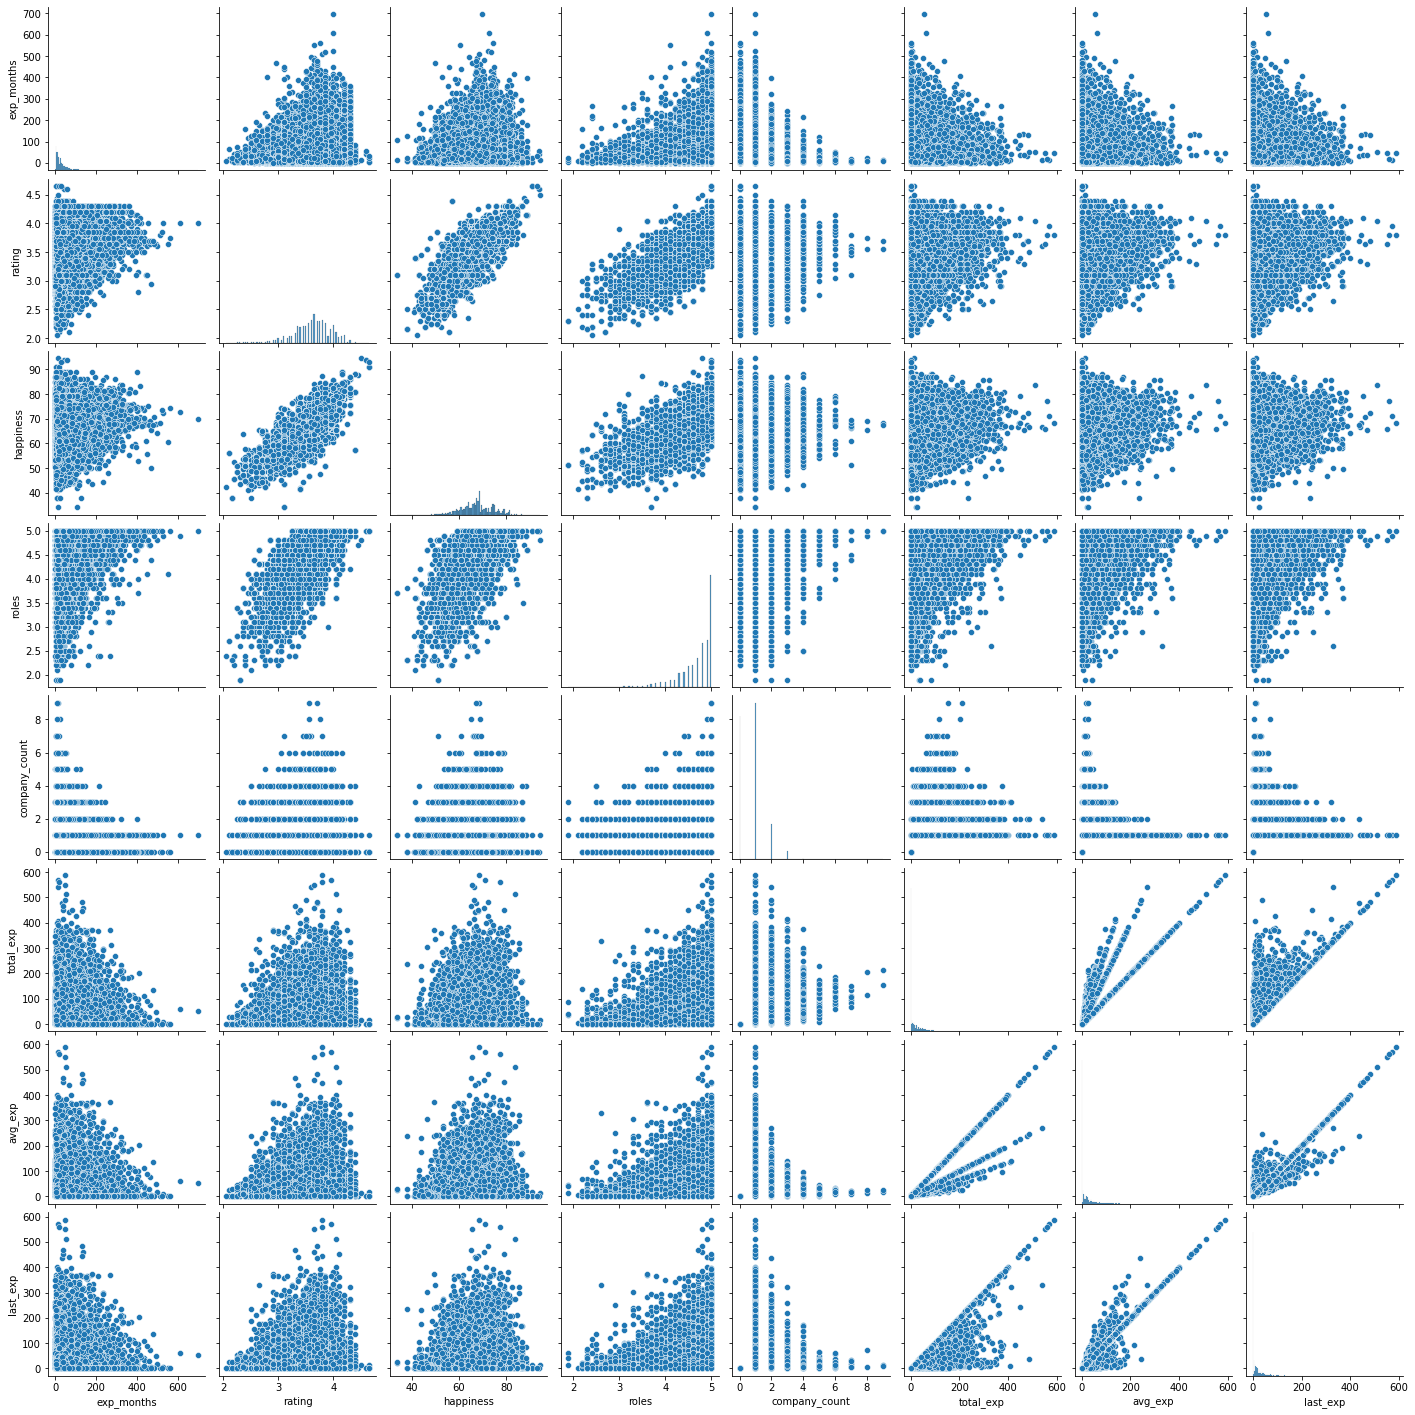

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample a fraction of the data for visualization
sampled_data = no_null.toPandas()
sampled_data.drop(['has_bachelor', 'has_master', 'has_doctor'], axis=1, inplace=True)
# Pairplot for numerical features
sns.pairplot(sampled_data)
plt.show()

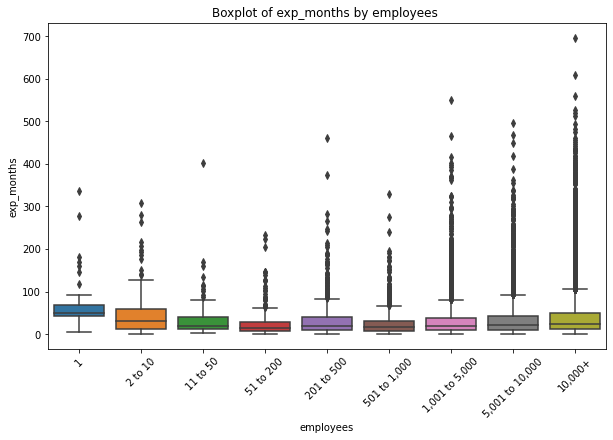

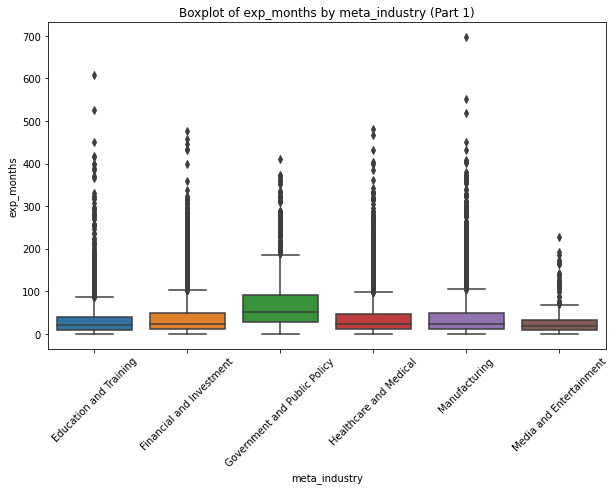

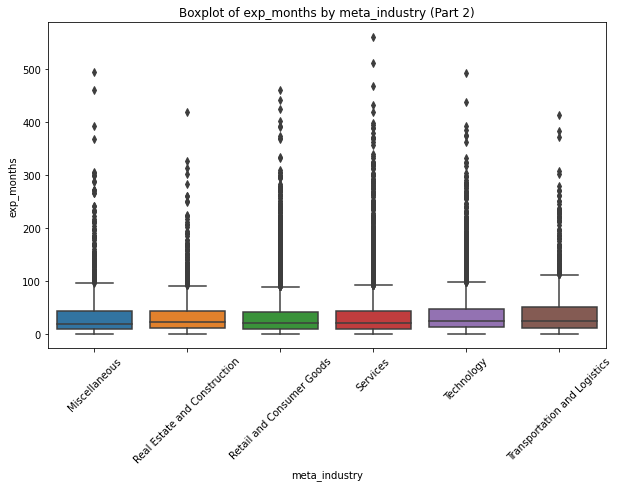

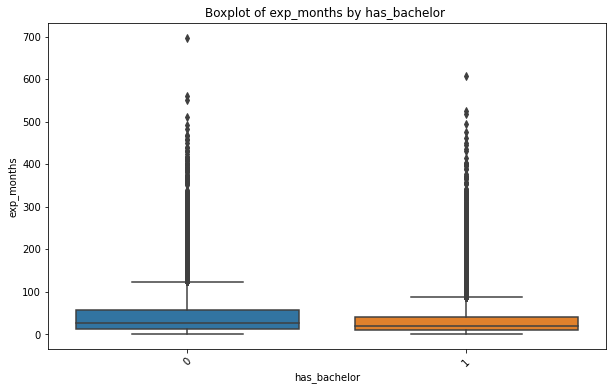

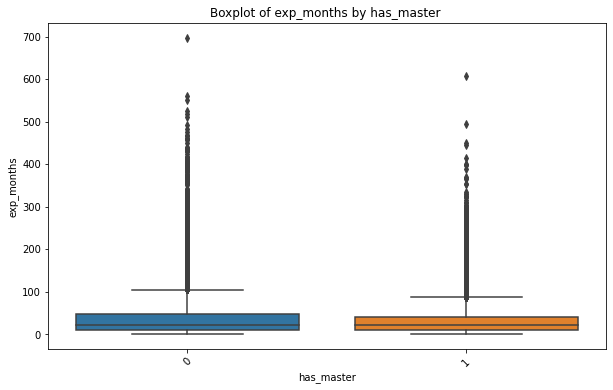

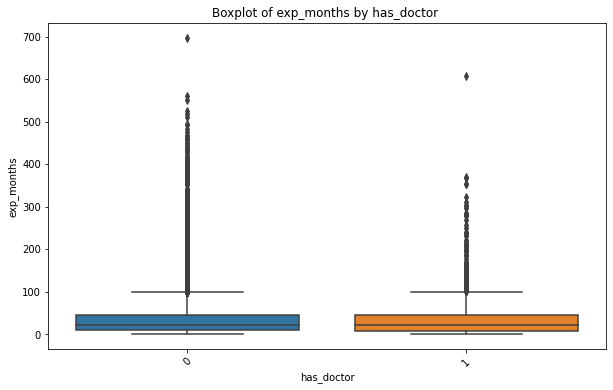

In [0]:
columns_to_select = ['exp_months', 'has_bachelor', 'has_master', 'has_doctor', 'employees', 'meta_industry']
pandas_df = no_null.select(*columns_to_select).toPandas()

# Function to plot boxplot for a given feature
def plot_boxplot(dataframe, feature_name, target='exp_months', order=None, title_suffix=''):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature_name, y=target, data=dataframe, order=order)
    plt.title(f'Boxplot of {target} by {feature_name} {title_suffix}')
    plt.xlabel(feature_name)
    plt.ylabel(target)
    plt.xticks(rotation=45)
    plt.show()

# Plotting boxplots for each feature
categorical_features = ['employees', 'meta_industry']  # Update this list if you have more categorical features
binary_features = ['has_bachelor', 'has_master', 'has_doctor']  # Update this list if you have more binary features
employees_order = ['1', '2 to 10', '11 to 50', '51 to 200', '201 to 500', '501 to 1,000', '1,001 to 5,000', '5,001 to 10,000', '10,000+']
# Sort the categories if necessary or desired
meta_industries = pandas_df['meta_industry'].unique()
meta_industries.sort()
# Split the categories into two groups
midpoint = len(meta_industries) // 2
meta_industries_first_half = meta_industries[:midpoint]
meta_industries_second_half = meta_industries[midpoint:]
    
for feature in categorical_features + binary_features:
    if feature == 'employees':
        plot_boxplot(pandas_df, 'employees', order=employees_order)
    elif feature == 'meta_industry':
        plot_boxplot(pandas_df, 'meta_industry', order=meta_industries_first_half, title_suffix='(Part 1)')
        # And then, plot the second half
        plot_boxplot(pandas_df, 'meta_industry', order=meta_industries_second_half, title_suffix='(Part 2)')
    else:
        plot_boxplot(pandas_df, feature)
        meta_industries = pandas_df['meta_industry'].unique()


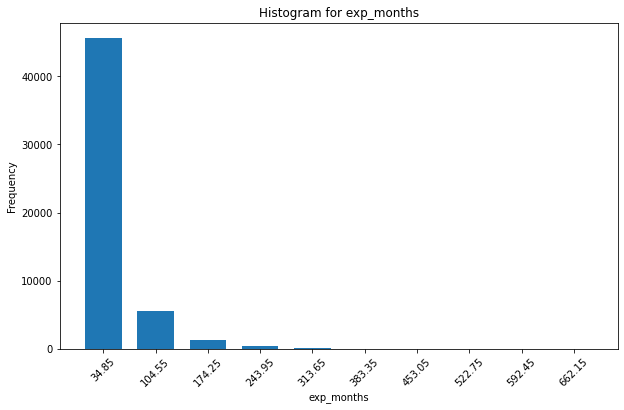

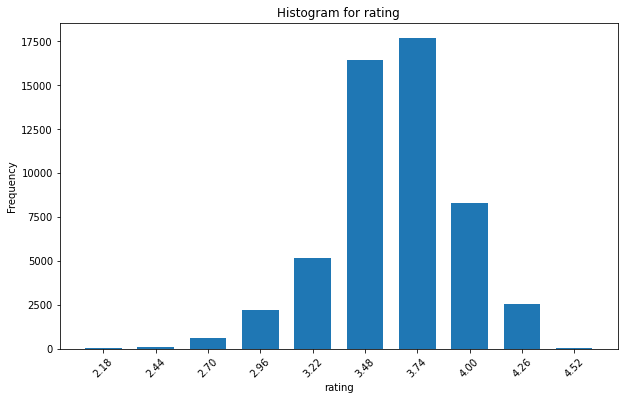

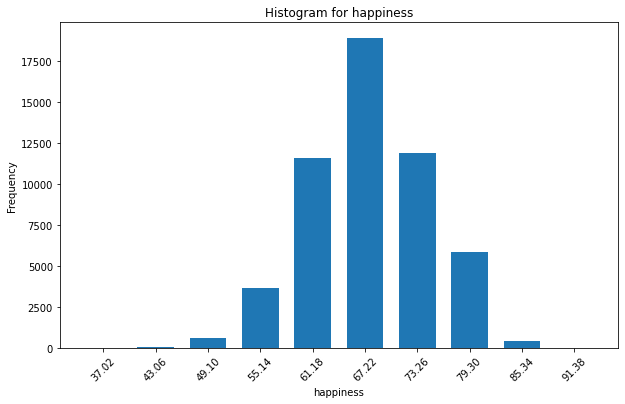

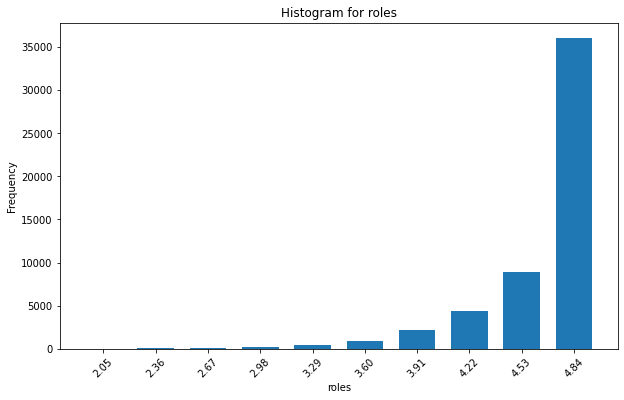

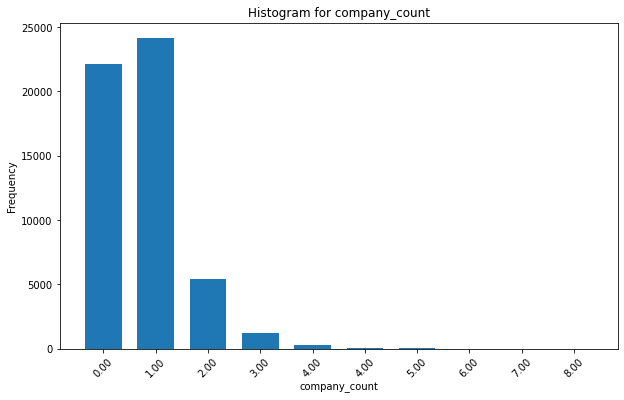

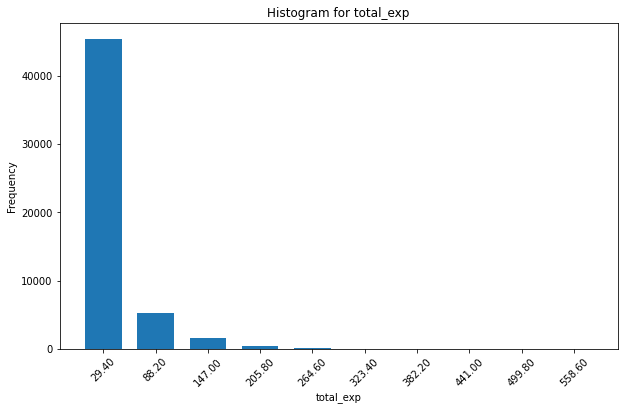

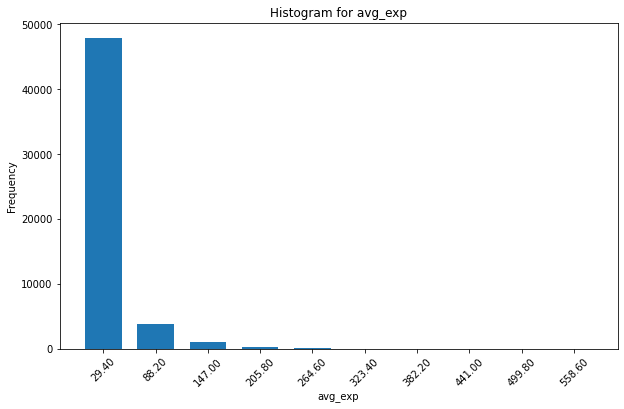

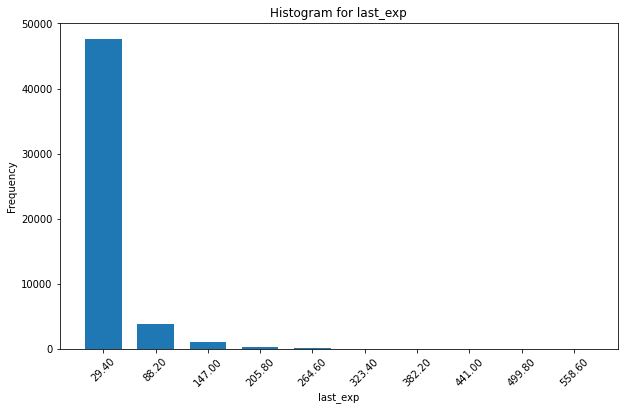

In [0]:
for col_name in numerical_features:
    # Compute the histogram data
    histogram = no_null.select(col_name).rdd.flatMap(lambda x: x).histogram(10)
    
    # Extracting the histogram data
    bins = histogram[0]
    counts = histogram[1]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(counts)), counts, width=0.7, align='center')
    if col_name == 'company_count':
        plt.xticks(range(len(counts)), ['{:.2f}'.format(int((bins[i] + bins[i+1])/2)) for i in range(len(bins)-1)], rotation=45)
    else:
        plt.xticks(range(len(counts)), ['{:.2f}'.format((bins[i] + bins[i+1])/2) for i in range(len(bins)-1)], rotation=45)
    plt.title(f"Histogram for {col_name}")
    plt.xlabel(col_name)
    plt.ylabel("Frequency")
    plt.show()


### Regression Imputation

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# Indexing
meta_industry_indexer = StringIndexer(inputCol="meta_industry", outputCol="meta_industry_index")
employees_indexer = StringIndexer(inputCol="employees", outputCol="employees_index")

# One-hot encoding
meta_industry_encoder = OneHotEncoder(inputCol="meta_industry_index", outputCol="meta_industry_vec")
employees_encoder = OneHotEncoder(inputCol="employees_index", outputCol="employees_vec")


In [0]:
# Assemble features
vector_assembler = VectorAssembler(inputCols=["meta_industry_vec", "employees_vec"], outputCol="features")

# Define linear regression model
lr = LinearRegression(featuresCol="features", labelCol="rating")

# Pipeline for the first imputation task (rating)
pipeline_rating = Pipeline(stages=[meta_industry_indexer, employees_indexer,
                                    meta_industry_encoder, employees_encoder,
                                    vector_assembler, lr])


In [0]:
# Filter rows where 'rating' is not missing
data_non_missing_rating = original_df.filter(original_df.rating.isNotNull())

# Fit the pipeline on data with non-missing 'rating'
model_rating = pipeline_rating.fit(data_non_missing_rating)

# Predict 'rating' for all data
predictions_rating = model_rating.transform(original_df)

# Update original_df with imputed 'rating' values
from pyspark.sql.functions import coalesce
imputed_df = predictions_rating.withColumn("rating", 
                                           coalesce(original_df["rating"],
                                                    when(predictions_rating["prediction"] < 1, F.lit(1))
                                                    .when(predictions_rating["prediction"] > 5, F.lit(5))
                                                    .otherwise(predictions_rating["prediction"])))

In [0]:
imputed_df = imputed_df.select(["name", "clean_company_name", "exp_title", "exp_months", "rating", "happiness", "roles", "company_count", "meta_industry", "employees", "total_exp", "avg_exp", "last_exp", "has_bachelor", "has_master", "has_doctor"])
imputed_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in imputed_df.columns]).show()

+----+------------------+---------+----------+------+---------+-----+-------------+-------------+---------+---------+-------+--------+------------+----------+----------+
|name|clean_company_name|exp_title|exp_months|rating|happiness|roles|company_count|meta_industry|employees|total_exp|avg_exp|last_exp|has_bachelor|has_master|has_doctor|
+----+------------------+---------+----------+------+---------+-----+-------------+-------------+---------+---------+-------+--------+------------+----------+----------+
|   0|                 0|        0|         0|     0|    33002|18036|            0|            0|        0|        0|      0|       0|        9265|      9265|      9265|
+----+------------------+---------+----------+------+---------+-----+-------------+-------------+---------+---------+-------+--------+------------+----------+----------+



In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import coalesce


# Define linear regression model
lr = LinearRegression(featuresCol="features", labelCol="roles")

# Assemble features, including 'rating'
vector_assembler_roles = VectorAssembler(inputCols=["meta_industry_vec", "employees_vec", "rating"], outputCol="features")

# Define the linear regression model for 'roles'
lr_roles = LinearRegression(featuresCol="features", labelCol="roles")

# Pipeline for 'roles' imputation
pipeline_roles = Pipeline(stages=[meta_industry_indexer, employees_indexer,
                                    meta_industry_encoder, employees_encoder,
                                    vector_assembler_roles, lr_roles])

# Split the data based on missingness in 'roles'
data_non_missing_roles = imputed_df.filter(imputed_df.roles.isNotNull())

# Fit the model on data with non-missing 'roles'
model_roles = pipeline_roles.fit(data_non_missing_roles)

# Predict 'roles' for all data
predictions_roles = model_roles.transform(imputed_df)

# Update imputed_df with imputed 'roles' values
imputed_df = predictions_roles.withColumn("roles", 
                                           coalesce(imputed_df["roles"],
                                                    when(predictions_roles["prediction"] < 1, F.lit(1))
                                                    .when(predictions_roles["prediction"] > 5, F.lit(5))
                                                    .otherwise(predictions_roles["prediction"])))

In [0]:
imputed_df = imputed_df.select(["name", "clean_company_name", "exp_title", "exp_months", "rating", "happiness", "roles", "company_count", "meta_industry", "employees", "total_exp", "avg_exp", "last_exp", "has_bachelor", "has_master", "has_doctor"])
imputed_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in imputed_df.columns]).show()

+----+------------------+---------+----------+------+---------+-----+-------------+-------------+---------+---------+-------+--------+------------+----------+----------+
|name|clean_company_name|exp_title|exp_months|rating|happiness|roles|company_count|meta_industry|employees|total_exp|avg_exp|last_exp|has_bachelor|has_master|has_doctor|
+----+------------------+---------+----------+------+---------+-----+-------------+-------------+---------+---------+-------+--------+------------+----------+----------+
|   0|                 0|        0|         0|     0|    33002|    0|            0|            0|        0|        0|      0|       0|        9265|      9265|      9265|
+----+------------------+---------+----------+------+---------+-----+-------------+-------------+---------+---------+-------+--------+------------+----------+----------+



In [0]:
vector_assembler_happiness = VectorAssembler(inputCols=["meta_industry_vec", "employees_vec", "rating", "roles_imputed"], outputCol="features")

# Define the linear regression model for 'happiness'
lr_happiness = LinearRegression(featuresCol="features", labelCol="happiness")

# Pipeline for 'happiness' imputation
pipeline_happiness = Pipeline(stages=[meta_industry_indexer, employees_indexer,
                                    meta_industry_encoder, employees_encoder,
                                    vector_assembler_roles, lr_happiness])

# Split the data based on missingness in 'happiness'
data_non_missing_happiness = imputed_df.filter(imputed_df.happiness.isNotNull())

# Fit the model on data with non-missing 'happiness'
model_happiness = pipeline_happiness.fit(data_non_missing_happiness)

# Predict 'happiness' for all data
predictions_happiness = model_happiness.transform(imputed_df)

# Update imputed_df with imputed 'happiness' values
imputed_df = predictions_happiness.withColumn("happiness", 
                                           coalesce(imputed_df["happiness"],
                                                    when(predictions_happiness["prediction"] < 0, F.lit(0))
                                                    .when(predictions_happiness["prediction"] > 100, F.lit(100))
                                                    .otherwise(predictions_happiness["prediction"])))


In [0]:
imputed_df = imputed_df.select(["name", "clean_company_name", "exp_title", "exp_months", "rating", "happiness", "roles", "company_count", "meta_industry", "employees", "total_exp", "avg_exp", "last_exp", "has_bachelor", "has_master", "has_doctor"])
imputed_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in imputed_df.columns]).show()

+----+------------------+---------+----------+------+---------+-----+-------------+-------------+---------+---------+-------+--------+------------+----------+----------+
|name|clean_company_name|exp_title|exp_months|rating|happiness|roles|company_count|meta_industry|employees|total_exp|avg_exp|last_exp|has_bachelor|has_master|has_doctor|
+----+------------------+---------+----------+------+---------+-----+-------------+-------------+---------+---------+-------+--------+------------+----------+----------+
|   0|                 0|        0|         0|     0|        0|    0|            0|            0|        0|        0|      0|       0|        9265|      9265|      9265|
+----+------------------+---------+----------+------+---------+-----+-------------+-------------+---------+---------+-------+--------+------------+----------+----------+



In [0]:
imputed_df = imputed_df.dropna()
imputed_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in imputed_df.columns]).show()

+----+------------------+---------+----------+------+---------+-----+-------------+-------------+---------+---------+-------+--------+------------+----------+----------+
|name|clean_company_name|exp_title|exp_months|rating|happiness|roles|company_count|meta_industry|employees|total_exp|avg_exp|last_exp|has_bachelor|has_master|has_doctor|
+----+------------------+---------+----------+------+---------+-----+-------------+-------------+---------+---------+-------+--------+------------+----------+----------+
|   0|                 0|        0|         0|     0|        0|    0|            0|            0|        0|        0|      0|       0|           0|         0|         0|
+----+------------------+---------+----------+------+---------+-----+-------------+-------------+---------+---------+-------+--------+------------+----------+----------+



In [0]:
imputed_df.write.mode("overwrite").parquet("/FileStore/g45/imputed_df.parquet")

### Imputed data analysis

In [0]:
from pyspark.sql import functions as F
describe_df = imputed_df.select(numerical_features).describe()

# Looping through each numerical feature to round the summary statistics and convert to int if ends with .000
for column in describe_df.columns[1:]:  # Skipping the first column which is the summary statistics names
    describe_df = describe_df.withColumn(column, 
                                          F.when(F.col(column).cast('float').cast('int') == F.col(column).cast('float'), 
                                                 F.format_number(F.col(column).cast('float').cast('int'), 0))
                                          .otherwise(F.format_number(F.col(column).cast('float'), 4)))

# Display the rounded summary
display(describe_df)

summary exp_months rating happiness roles company_count total_exp avg_exp last_exp count 94,320 94,320 94,320 94,320 94,320 94,320 94,320 94,320 mean 37.0729 3.6209 67.8382 4.6374 0.7187 25.0044 20.4707 20.3945 stddev 45.5724 0.3404 6.9915 0.4123 0.7781 43.4553 36.9670 37.7040 min 0 1 21.4562 1.8000 0 0 0 0 max 727 5 95.6384 5 9 727 727 727

In [0]:
# Assemble numerical features into a vector
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features")
original_vector = assembler.transform(imputed_df).select("features")

# Compute the correlation matrix
original_matrix = Correlation.corr(original_vector, "features").collect()[0][0]
original_corrmatrix = np.array(original_matrix.toArray())

pd_corrmatrix = pd.DataFrame(original_corrmatrix, columns=numerical_features, index=numerical_features)

# Print the pandas DataFrame as a table
print("Original Correlation Matrix:")
print(pd_corrmatrix)

Original Correlation Matrix:
               exp_months    rating  happiness     roles  company_count  \
exp_months       1.000000  0.057167   0.035592  0.049092      -0.054021   
rating           0.057167  1.000000   0.885437  0.630417      -0.035675   
happiness        0.035592  0.885437   1.000000  0.558212      -0.036085   
roles            0.049092  0.630417   0.558212  1.000000      -0.000033   
company_count   -0.054021 -0.035675  -0.036085 -0.000033       1.000000   
total_exp        0.092523 -0.026880  -0.028284  0.001287       0.540352   
avg_exp          0.118029 -0.022505  -0.022695 -0.003530       0.357814   
last_exp         0.114999 -0.020965  -0.021397 -0.003114       0.346553   

               total_exp   avg_exp  last_exp  
exp_months      0.092523  0.118029  0.114999  
rating         -0.026880 -0.022505 -0.020965  
happiness      -0.028284 -0.022695 -0.021397  
roles           0.001287 -0.003530 -0.003114  
company_count   0.540352  0.357814  0.346553  
total_exp    

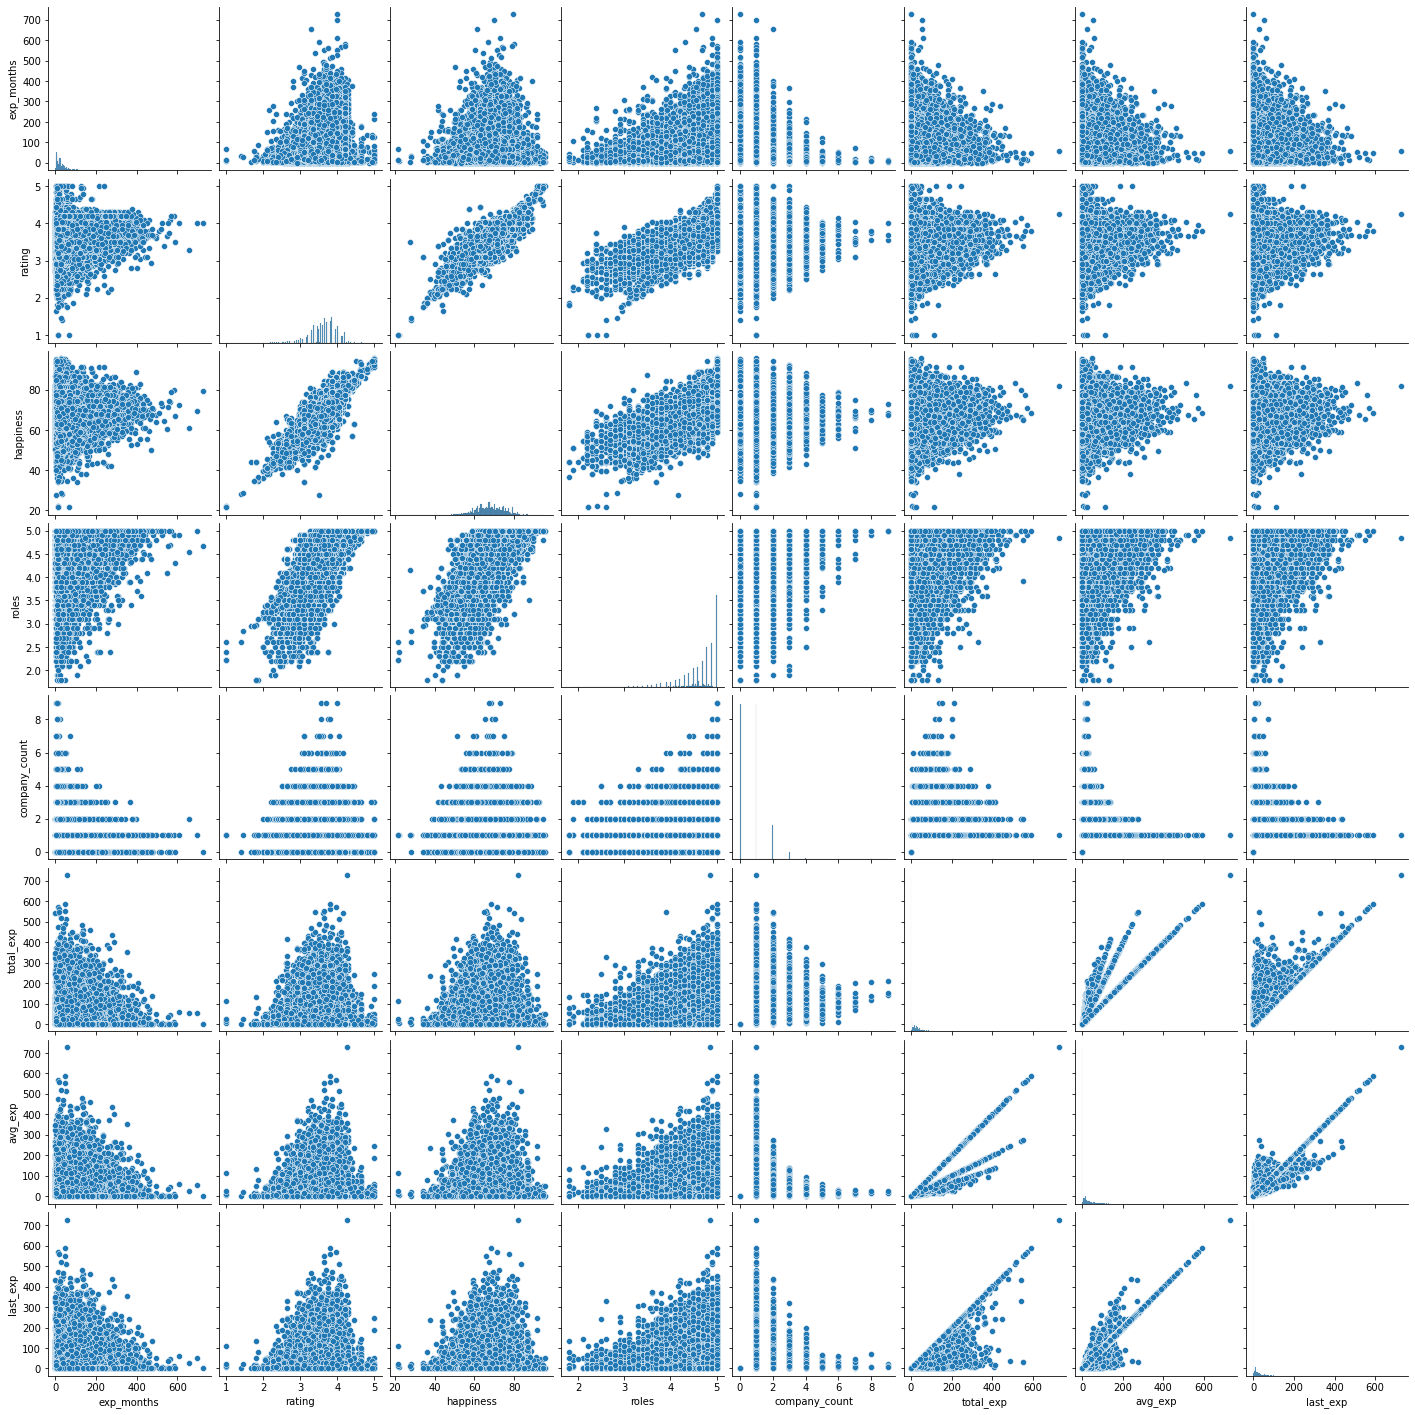

In [0]:
# Sample a fraction of the data for visualization
sampled_data = imputed_df.toPandas()
sampled_data.drop(['has_bachelor', 'has_master', 'has_doctor'], axis=1, inplace=True)
# Pairplot for numerical features
sns.pairplot(sampled_data)
plt.show()

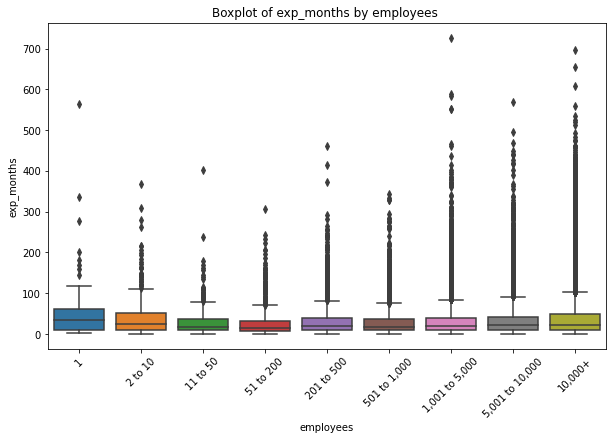

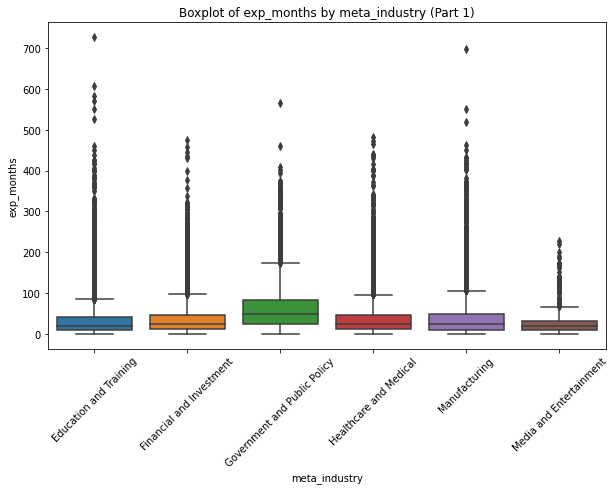

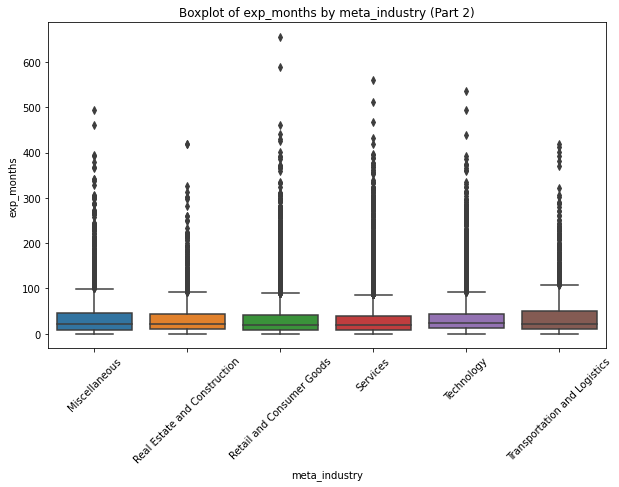

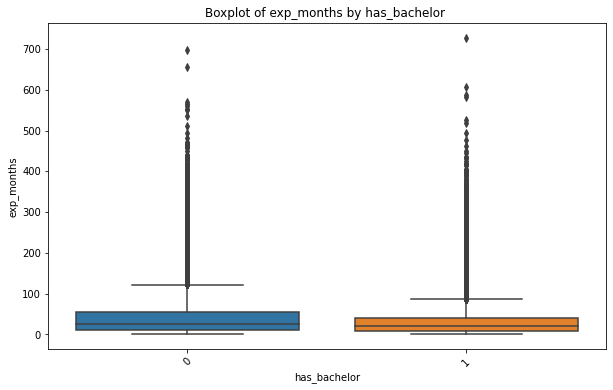

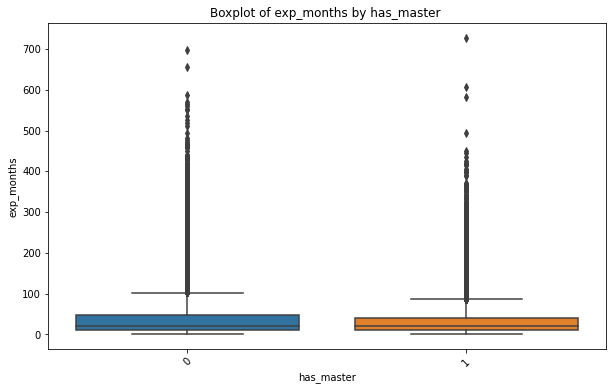

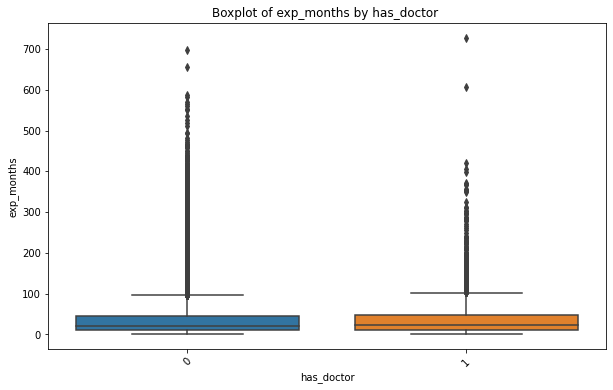

In [0]:
pandas_df = imputed_df.select(*columns_to_select).toPandas()
for feature in categorical_features + binary_features:
    if feature == 'employees':
        plot_boxplot(pandas_df, 'employees', order=employees_order)
    elif feature == 'meta_industry':
        plot_boxplot(pandas_df, 'meta_industry', order=meta_industries_first_half, title_suffix='(Part 1)')
        # And then, plot the second half
        plot_boxplot(pandas_df, 'meta_industry', order=meta_industries_second_half, title_suffix='(Part 2)')
    else:
        plot_boxplot(pandas_df, feature)
        meta_industries = pandas_df['meta_industry'].unique()

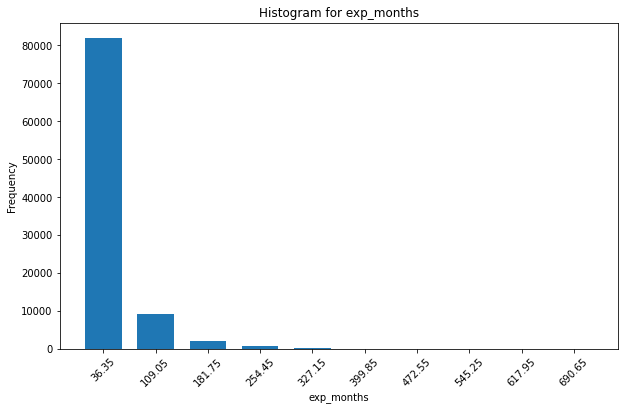

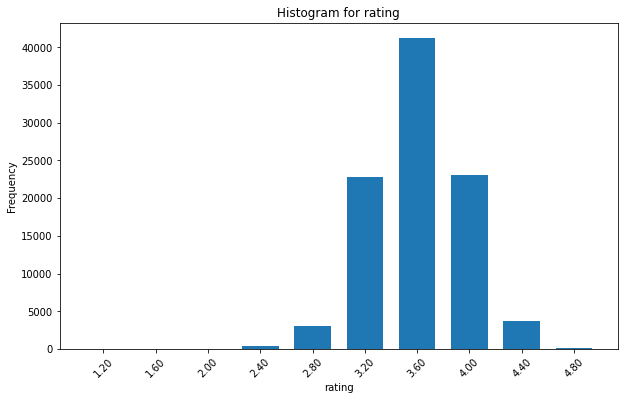

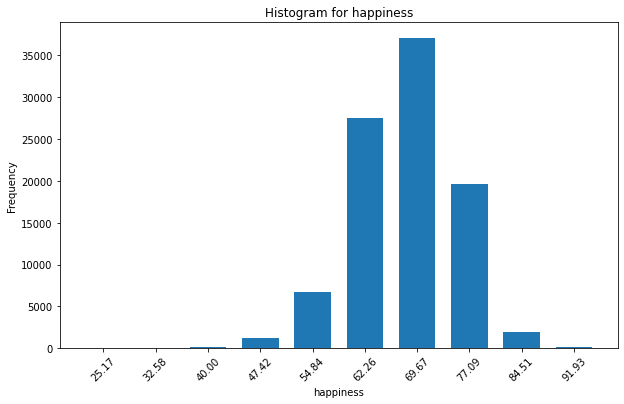

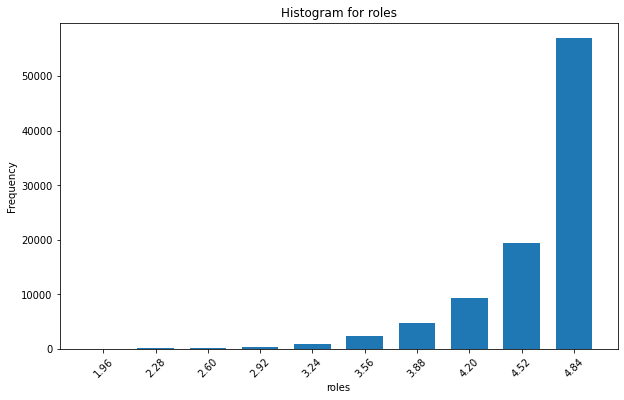

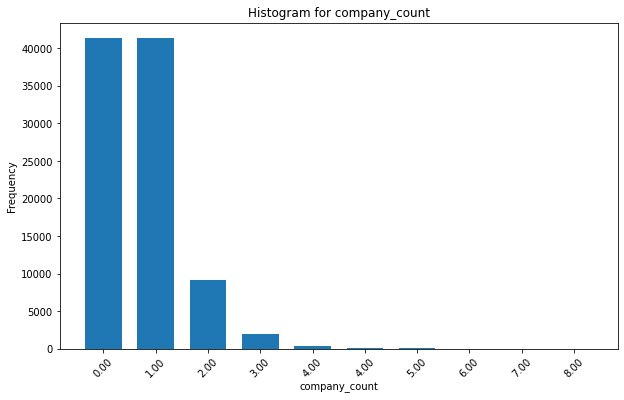

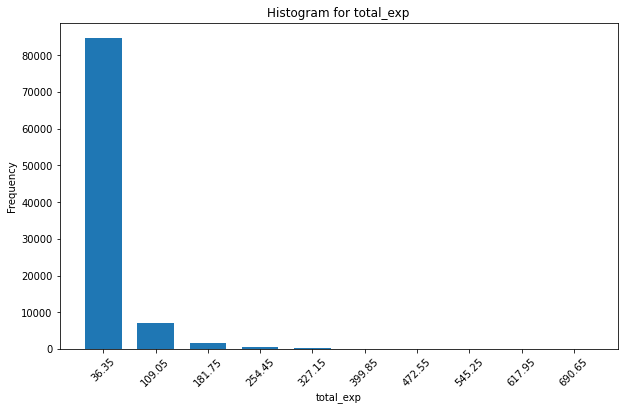

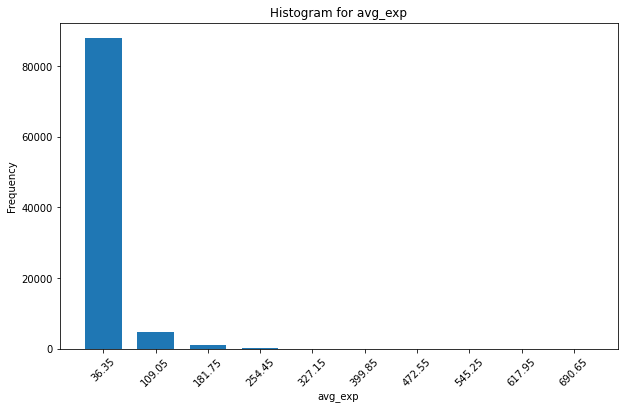

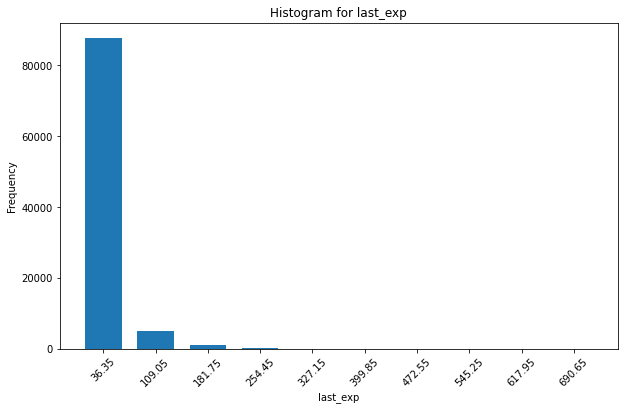

In [0]:
for col_name in numerical_features:
    # Compute the histogram data
    histogram = imputed_df.select(col_name).rdd.flatMap(lambda x: x).histogram(10)
    
    # Extracting the histogram data
    bins = histogram[0]
    counts = histogram[1]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(counts)), counts, width=0.7, align='center')
    if col_name == 'company_count':
        plt.xticks(range(len(counts)), ['{:.2f}'.format(int((bins[i] + bins[i+1])/2)) for i in range(len(bins)-1)], rotation=45)
    else:
        plt.xticks(range(len(counts)), ['{:.2f}'.format((bins[i] + bins[i+1])/2) for i in range(len(bins)-1)], rotation=45)
    plt.title(f"Histogram for {col_name}")
    plt.xlabel(col_name)
    plt.ylabel("Frequency")
    plt.show()
